In [15]:
import os
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

In [2]:
# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray'):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap=colormap, clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap=colormap, clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap=colormap, clim=(low, high), extent=(0, height, 0, depth))

    plt.show()

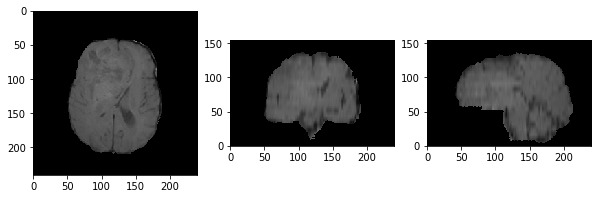

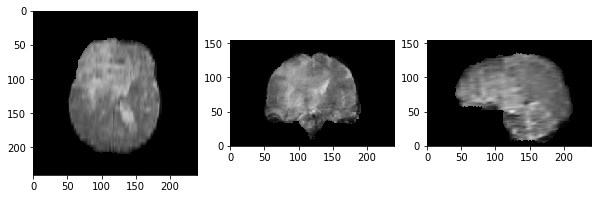

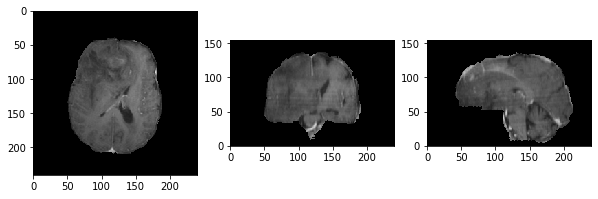

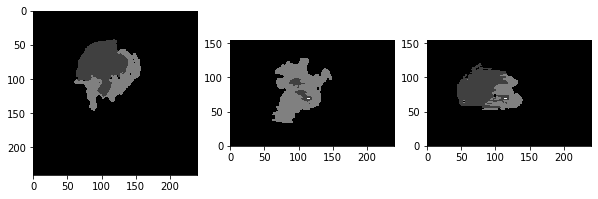

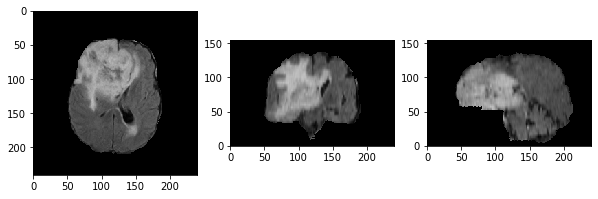

In [38]:
# Brats data path
data_dir_name = '../../Brats17TrainingData/LGG/'
samples = os.listdir(data_dir_name)

# Image
image_filename = data_dir + samples[3] + '/' + samples[3] + '_t1.nii.gz'
img = sitk.ReadImage(image_filename)

image2_filename = data_dir + samples[3] + '/' + samples[3] + '_t2.nii.gz'
img2 = sitk.ReadImage(image2_filename)

image3_filename = data_dir + samples[3] + '/' + samples[3] + '_t1ce.nii.gz'
img3 = sitk.ReadImage(image3_filename)

image4_filename = data_dir + samples[3] + '/' + samples[3] + '_seg.nii.gz'
img4 = sitk.ReadImage(image4_filename)

image5_filename = data_dir + samples[3] + '/' + samples[3] + '_flair.nii.gz'
img5 = sitk.ReadImage(image5_filename)

display_image(img)
display_image(img2)
display_image(img3)
display_image(img4)
display_image(img5)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [53]:
def zero_mean_unit_var(image):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    mean = np.mean(img_array[img_array>0])
    std = np.std(img_array[img_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
#         img_array[img_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing), -1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, file_list_seg, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)
            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            #pre=processing
            img = zero_mean_unit_var(img)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)

        return {'img': image, 'seg': seg}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]

In [49]:
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

print('Device: ' + str(device))

Device: cuda:6


In [59]:
rnd_seed = 42 #fixed random seed

img_size = [99,99,99]
img_spacing = [2.4,2.4,2.4]

num_epochs = 150
learning_rate = 0.01
batch_size = 8
val_interval = 10

num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [60]:
files_seg_img = [data_dir_name + s + '/' + s + '_flair.nii.gz' for s in samples]
files_seg_seg = [data_dir_name + s + '/' + s + '_seg.nii.gz' for s in samples]

# LOAD ACTUAL TRAINING DATA
dataset_train = ImageSegmentationDataset(files_seg_img[:55], files_seg_seg[:55], img_spacing, img_size)
# LOAD VALIDATION DATA AS TRAINING FOR QUICK DEBUGGING
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = ImageSegmentationDataset(files_seg_img[55:65], files_seg_seg[55:65], img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


Image: Brats17_TCIA_633_1_flair.nii.gz


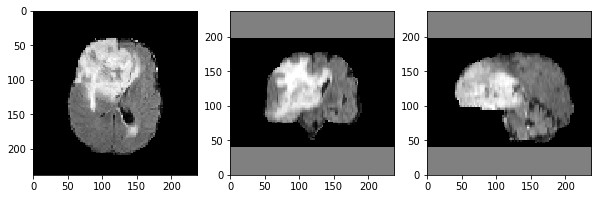

Segmentation


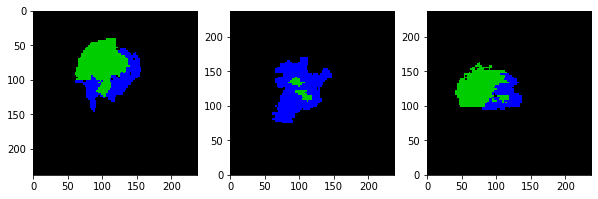

(99, 99, 99)


In [61]:
sample = dataset_train.get_sample(3)
img_name = dataset_train.get_img_name(3)
seg_name = dataset_train.get_seg_name(3)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print(sample['img'].GetSize())

In [44]:
class SimpleNet3D(nn.Module):

    def __init__(self, num_classes):
        super(SimpleNet3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(4, 8, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(8, 4, kernel_size=3, padding=1)
        self.conv4 = nn.Conv3d(4, num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        return F.softmax(x, dim=1)


#Downsampling component of the U-Net
class UnetDown(nn.Module):

    def __init__(self, in_channels,out_channels):
        super(UnetDown, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3,padding=1)
        self.batch_norm = nn.BatchNorm3d(out_channels)
        self.pool  = nn.MaxPool3d(2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.batch_norm(x))
        x_downsample = self.pool(x)
        return x, x_downsample


#Upsampling of the U-Net
class UnetUp(nn.Module):

    def __init__(self, in_channels):
        super(UnetUp, self).__init__()
        self.upconv = nn.ConvTranspose3d(in_channels, in_channels, kernel_size=2, stride=2)
        self.conv1 = nn.Conv3d(2 * in_channels, int(in_channels / 2), kernel_size=3,padding=1)
        self.batch_norm = nn.BatchNorm3d(int(in_channels/2))
  
    def forward(self, x_up, x_down):
        x_up = self.upconv(x_up)
        concat_fm = torch.cat((x_up, x_down), 1)
        x = self.conv1(concat_fm)
        x = F.relu(self.batch_norm(x))
        return x

class Unet(nn.Module):
  
    def __init__(self,in_channels, out_channels, num_classes):
        super(Unet,self).__init__()
        self.encode1 = UnetDown(in_channels, out_channels)
        self.encode2 = UnetDown(out_channels, 2 * out_channels)
        self.conv1 = nn.Conv3d(2 * out_channels, 2 * out_channels, kernel_size=3, padding=1)
        self.decode1 = UnetUp(2 * out_channels)
        self.decode2 = UnetUp(out_channels)
        self.out_conv = nn.Conv3d(int(out_channels/2),num_classes,kernel_size=3)


    def forward(self, x):
        enc1 = self.encode1(x)
        enc2 = self.encode2(enc1[1])
        x1 = self.conv1(enc2[1])
        dec1 = self.decode1(x1,enc2[0])
        dec2 = self.decode2(dec1,enc1[0])
        x_out = self.out_conv(dec2)
        x_out = F.softmax(dec2, dim=1)
        return x_out

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 2.756575
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 2.738226


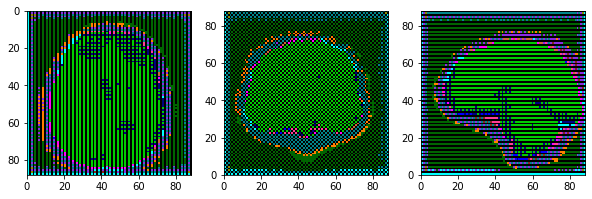

--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 2.728262
+ TRAINING 	Epoch: 3 	Loss: 2.712370
+ TRAINING 	Epoch: 4 	Loss: 2.694587
+ TRAINING 	Epoch: 5 	Loss: 2.676426
+ TRAINING 	Epoch: 6 	Loss: 2.653959
+ TRAINING 	Epoch: 7 	Loss: 2.634711
+ TRAINING 	Epoch: 8 	Loss: 2.617942
+ TRAINING 	Epoch: 9 	Loss: 2.598864
+ TRAINING 	Epoch: 10 	Loss: 2.582849
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 2.579593


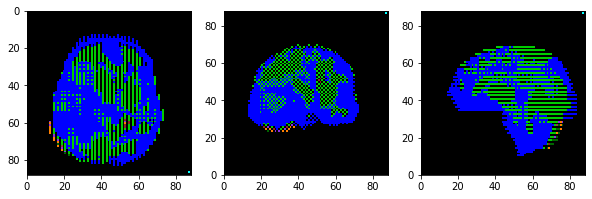

--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 2.566554
+ TRAINING 	Epoch: 12 	Loss: 2.549454
+ TRAINING 	Epoch: 13 	Loss: 2.534543
+ TRAINING 	Epoch: 14 	Loss: 2.518457
+ TRAINING 	Epoch: 15 	Loss: 2.502567
+ TRAINING 	Epoch: 16 	Loss: 2.479452
+ TRAINING 	Epoch: 17 	Loss: 2.465432
+ TRAINING 	Epoch: 18 	Loss: 2.453057
+ TRAINING 	Epoch: 19 	Loss: 2.443647
+ TRAINING 	Epoch: 20 	Loss: 2.431061
--------------------------------------------------
+ VALIDATE 	Epoch: 20 	Loss: 2.430459


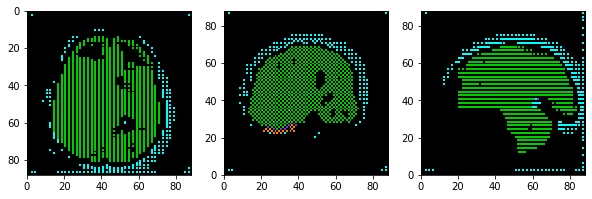

--------------------------------------------------
+ TRAINING 	Epoch: 21 	Loss: 2.419181
+ TRAINING 	Epoch: 22 	Loss: 2.412246
+ TRAINING 	Epoch: 23 	Loss: 2.403124
+ TRAINING 	Epoch: 24 	Loss: 2.397681
+ TRAINING 	Epoch: 25 	Loss: 2.393051
+ TRAINING 	Epoch: 26 	Loss: 2.390969
+ TRAINING 	Epoch: 27 	Loss: 2.379910
+ TRAINING 	Epoch: 28 	Loss: 2.380721
+ TRAINING 	Epoch: 29 	Loss: 2.376557
+ TRAINING 	Epoch: 30 	Loss: 2.370409
--------------------------------------------------
+ VALIDATE 	Epoch: 30 	Loss: 2.373093


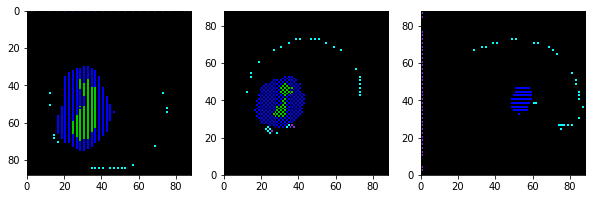

--------------------------------------------------
+ TRAINING 	Epoch: 31 	Loss: 2.371612
+ TRAINING 	Epoch: 32 	Loss: 2.364643
+ TRAINING 	Epoch: 33 	Loss: 2.362478
+ TRAINING 	Epoch: 34 	Loss: 2.365742
+ TRAINING 	Epoch: 35 	Loss: 2.360154
+ TRAINING 	Epoch: 36 	Loss: 2.358765
+ TRAINING 	Epoch: 37 	Loss: 2.359711
+ TRAINING 	Epoch: 38 	Loss: 2.357185
+ TRAINING 	Epoch: 39 	Loss: 2.357034
+ TRAINING 	Epoch: 40 	Loss: 2.352298
--------------------------------------------------
+ VALIDATE 	Epoch: 40 	Loss: 2.354389


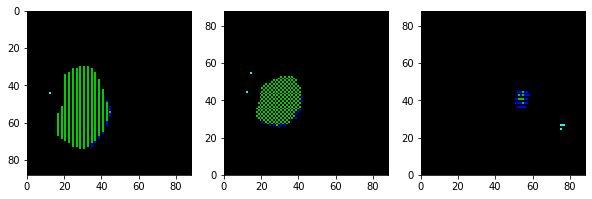

--------------------------------------------------
+ TRAINING 	Epoch: 41 	Loss: 2.350491
+ TRAINING 	Epoch: 42 	Loss: 2.351603
+ TRAINING 	Epoch: 43 	Loss: 2.351658
+ TRAINING 	Epoch: 44 	Loss: 2.349248
+ TRAINING 	Epoch: 45 	Loss: 2.352275
+ TRAINING 	Epoch: 46 	Loss: 2.352030
+ TRAINING 	Epoch: 47 	Loss: 2.349645
+ TRAINING 	Epoch: 48 	Loss: 2.349757
+ TRAINING 	Epoch: 49 	Loss: 2.343078
+ TRAINING 	Epoch: 50 	Loss: 2.347287
--------------------------------------------------
+ VALIDATE 	Epoch: 50 	Loss: 2.347707


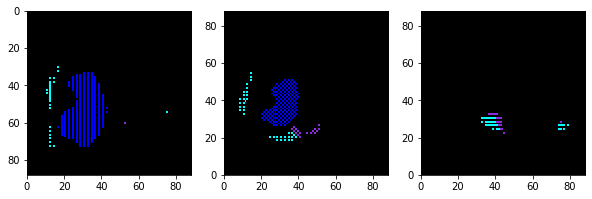

--------------------------------------------------
+ TRAINING 	Epoch: 51 	Loss: 2.345909
+ TRAINING 	Epoch: 52 	Loss: 2.343697
+ TRAINING 	Epoch: 53 	Loss: 2.343145
+ TRAINING 	Epoch: 54 	Loss: 2.345867
+ TRAINING 	Epoch: 55 	Loss: 2.347193
+ TRAINING 	Epoch: 56 	Loss: 2.343098
+ TRAINING 	Epoch: 57 	Loss: 2.342437
+ TRAINING 	Epoch: 58 	Loss: 2.342478
+ TRAINING 	Epoch: 59 	Loss: 2.342054
+ TRAINING 	Epoch: 60 	Loss: 2.341255
--------------------------------------------------
+ VALIDATE 	Epoch: 60 	Loss: 2.342915


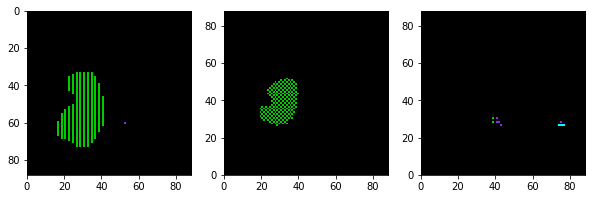

--------------------------------------------------
+ TRAINING 	Epoch: 61 	Loss: 2.342265
+ TRAINING 	Epoch: 62 	Loss: 2.342728
+ TRAINING 	Epoch: 63 	Loss: 2.340630
+ TRAINING 	Epoch: 64 	Loss: 2.339418
+ TRAINING 	Epoch: 65 	Loss: 2.339319
+ TRAINING 	Epoch: 66 	Loss: 2.340364
+ TRAINING 	Epoch: 67 	Loss: 2.337730
+ TRAINING 	Epoch: 68 	Loss: 2.341696
+ TRAINING 	Epoch: 69 	Loss: 2.337569
+ TRAINING 	Epoch: 70 	Loss: 2.311192
--------------------------------------------------
+ VALIDATE 	Epoch: 70 	Loss: 2.258365


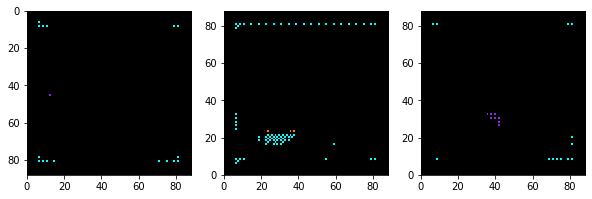

--------------------------------------------------
+ TRAINING 	Epoch: 71 	Loss: 2.237291
+ TRAINING 	Epoch: 72 	Loss: 2.204154
+ TRAINING 	Epoch: 73 	Loss: 2.176717
+ TRAINING 	Epoch: 74 	Loss: 2.156643
+ TRAINING 	Epoch: 75 	Loss: 2.148367
+ TRAINING 	Epoch: 76 	Loss: 2.125539
+ TRAINING 	Epoch: 77 	Loss: 2.132981
+ TRAINING 	Epoch: 78 	Loss: 2.102215
+ TRAINING 	Epoch: 79 	Loss: 2.096333
+ TRAINING 	Epoch: 80 	Loss: 2.091083
--------------------------------------------------
+ VALIDATE 	Epoch: 80 	Loss: 2.085175


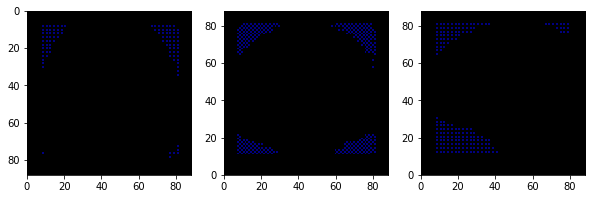

--------------------------------------------------
+ TRAINING 	Epoch: 81 	Loss: 2.064673
+ TRAINING 	Epoch: 82 	Loss: 2.054670
+ TRAINING 	Epoch: 83 	Loss: 2.045183
+ TRAINING 	Epoch: 84 	Loss: 2.052054
+ TRAINING 	Epoch: 85 	Loss: 2.039734
+ TRAINING 	Epoch: 86 	Loss: 2.041798
+ TRAINING 	Epoch: 87 	Loss: 2.036196
+ TRAINING 	Epoch: 88 	Loss: 2.014633
+ TRAINING 	Epoch: 89 	Loss: 2.030042
+ TRAINING 	Epoch: 90 	Loss: 1.993432
--------------------------------------------------
+ VALIDATE 	Epoch: 90 	Loss: 1.994964


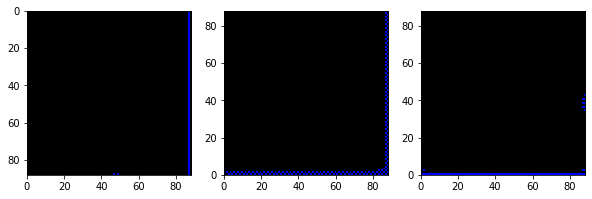

--------------------------------------------------
+ TRAINING 	Epoch: 91 	Loss: 1.986056
+ TRAINING 	Epoch: 92 	Loss: 1.984022
+ TRAINING 	Epoch: 93 	Loss: 1.967345
+ TRAINING 	Epoch: 94 	Loss: 1.968861
+ TRAINING 	Epoch: 95 	Loss: 1.968410
+ TRAINING 	Epoch: 96 	Loss: 1.953726
+ TRAINING 	Epoch: 97 	Loss: 1.960962
+ TRAINING 	Epoch: 98 	Loss: 1.952715
+ TRAINING 	Epoch: 99 	Loss: 1.957640
+ TRAINING 	Epoch: 100 	Loss: 1.949804
--------------------------------------------------
+ VALIDATE 	Epoch: 100 	Loss: 1.952680


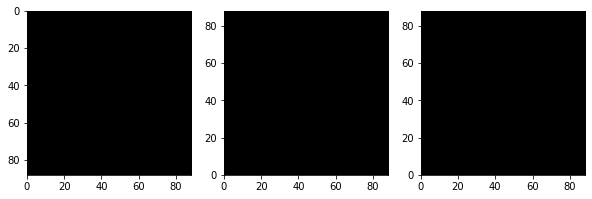

--------------------------------------------------
+ TRAINING 	Epoch: 101 	Loss: 1.948991
+ TRAINING 	Epoch: 102 	Loss: 1.956972
+ TRAINING 	Epoch: 103 	Loss: 1.945238
+ TRAINING 	Epoch: 104 	Loss: 1.943481
+ TRAINING 	Epoch: 105 	Loss: 1.934868
+ TRAINING 	Epoch: 106 	Loss: 1.941867
+ TRAINING 	Epoch: 107 	Loss: 1.933763
+ TRAINING 	Epoch: 108 	Loss: 1.938396
+ TRAINING 	Epoch: 109 	Loss: 1.938405
+ TRAINING 	Epoch: 110 	Loss: 1.933133
--------------------------------------------------
+ VALIDATE 	Epoch: 110 	Loss: 1.939008


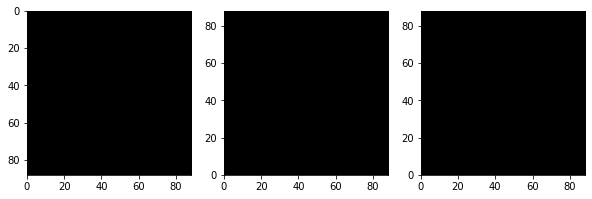

--------------------------------------------------
+ TRAINING 	Epoch: 111 	Loss: 1.934538
+ TRAINING 	Epoch: 112 	Loss: 1.932153
+ TRAINING 	Epoch: 113 	Loss: 1.932495
+ TRAINING 	Epoch: 114 	Loss: 1.932222
+ TRAINING 	Epoch: 115 	Loss: 1.927401
+ TRAINING 	Epoch: 116 	Loss: 1.929625
+ TRAINING 	Epoch: 117 	Loss: 1.934391
+ TRAINING 	Epoch: 118 	Loss: 1.935360
+ TRAINING 	Epoch: 119 	Loss: 1.930273
+ TRAINING 	Epoch: 120 	Loss: 1.923258
--------------------------------------------------
+ VALIDATE 	Epoch: 120 	Loss: 1.932161


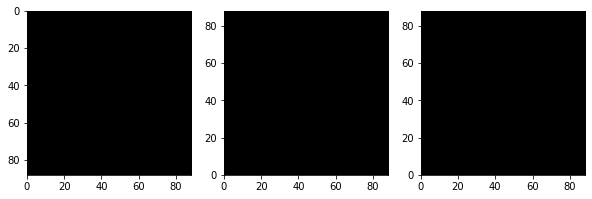

--------------------------------------------------
+ TRAINING 	Epoch: 121 	Loss: 1.927070
+ TRAINING 	Epoch: 122 	Loss: 1.921561
+ TRAINING 	Epoch: 123 	Loss: 1.923874
+ TRAINING 	Epoch: 124 	Loss: 1.924414
+ TRAINING 	Epoch: 125 	Loss: 1.920966
+ TRAINING 	Epoch: 126 	Loss: 1.930165
+ TRAINING 	Epoch: 127 	Loss: 1.929259
+ TRAINING 	Epoch: 128 	Loss: 1.921881
+ TRAINING 	Epoch: 129 	Loss: 1.927981
+ TRAINING 	Epoch: 130 	Loss: 1.925274
--------------------------------------------------
+ VALIDATE 	Epoch: 130 	Loss: 1.928043


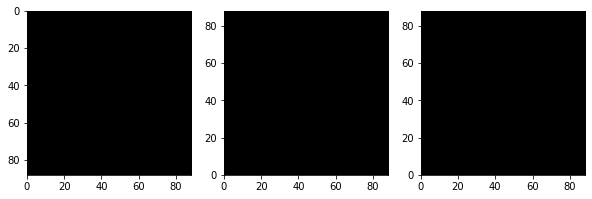

--------------------------------------------------
+ TRAINING 	Epoch: 131 	Loss: 1.928259
+ TRAINING 	Epoch: 132 	Loss: 1.926510
+ TRAINING 	Epoch: 133 	Loss: 1.928201
+ TRAINING 	Epoch: 134 	Loss: 1.920671
+ TRAINING 	Epoch: 135 	Loss: 1.916124
+ TRAINING 	Epoch: 136 	Loss: 1.924394
+ TRAINING 	Epoch: 137 	Loss: 1.920839
+ TRAINING 	Epoch: 138 	Loss: 1.919654
+ TRAINING 	Epoch: 139 	Loss: 1.917877
+ TRAINING 	Epoch: 140 	Loss: 1.924719
--------------------------------------------------
+ VALIDATE 	Epoch: 140 	Loss: 1.925297


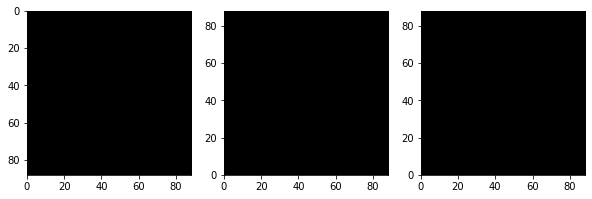

--------------------------------------------------
+ TRAINING 	Epoch: 141 	Loss: 1.920113
+ TRAINING 	Epoch: 142 	Loss: 1.918698
+ TRAINING 	Epoch: 143 	Loss: 1.916038
+ TRAINING 	Epoch: 144 	Loss: 1.922408
+ TRAINING 	Epoch: 145 	Loss: 1.922566
+ TRAINING 	Epoch: 146 	Loss: 1.918210
+ TRAINING 	Epoch: 147 	Loss: 1.926127
+ TRAINING 	Epoch: 148 	Loss: 1.920099
+ TRAINING 	Epoch: 149 	Loss: 1.920408
+ TRAINING 	Epoch: 150 	Loss: 1.920145
--------------------------------------------------
+ VALIDATE 	Epoch: 150 	Loss: 1.923339


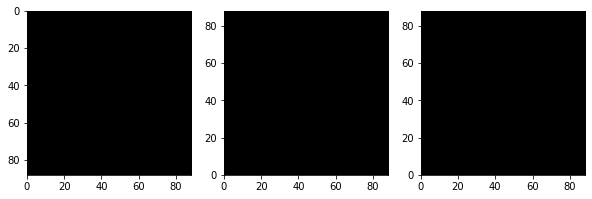

--------------------------------------------------

Finished TRAINING.


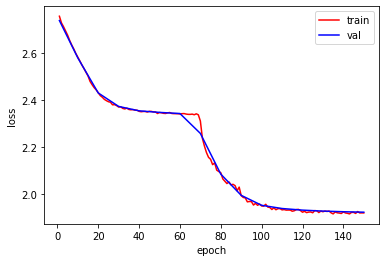

In [45]:
torch.cuda.empty_cache()

model_dir = os.path.join(out_dir, 'segmentation_model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

model = Unet(1,32,4).to(device)
model.train()
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train_log = []
loss_val_log = []
epoch_val_log = []
    
print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss = F.cross_entropy(prd_flat, seg_flat.squeeze(1))
        del img
        del seg
        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    
    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        with torch.no_grad():
            for data_sample in dataloader_val:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd = model(img)
                prd_flat = prd.view(prd.size(0), prd.size(1), -1)
                seg_flat = seg.view(seg.size(0), seg.size(1), -1)
                loss_val += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
                sum_pts += seg_flat.size(2)
                
        prd = torch.argmax(prd, dim=1)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        

        loss_val /= sum_pts

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)

        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
        display_image(sitk.LabelToRGB(prediction))
        print('--------------------------------------------------')

torch.save(model.state_dict(), os.path.join(model_dir, 'model2.pt'))

print('\nFinished TRAINING.')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()